In [1]:
# imports

# ---- external
from scipy.io import loadmat
from scipy.stats import kurtosis, skew
import pandas as pd
import numpy as np

# ---- system
from genericpath import isfile
from os import getcwd, listdir

In [8]:
path=r'/Users/harshdhiman/Documents/Research /Codes/WT-HSB-Prognosis/Data'

In [9]:
import sys
import os
os.chdir(path)
data = []
for i in os.listdir():
  data.append(loadmat(i)['vibration'].flatten())

data = np.array(data).flatten() # all data of 50 days is merged into a single arr
print(sys.getsizeof(data)) # 234374512 bytes || 230ish MB

234374512


In [10]:
data.shape

(29296800,)

In [4]:
def SWAT(x,alpha,window_length,window_shift):

    # returns a 2d array where each child array is the calculated window
    def SlidingWindow(data, window_length, window_shift):
        mov = np.lib.stride_tricks.sliding_window_view(data, window_length)[::window_shift]
        return np.array(mov)

    mov=SlidingWindow(x, window_length, window_shift)
    # print(mov) # 2D Array [[window data 1], [window data 2], ...., [window data N-1], [window data N]]

    # mean=[]
    # std=[]
    # kurt=[]
    # skewness=[]
    # maximum=[]
    # minimum=[]

    # for i in range(mov.shape[0]):
    #     mean.append(np.mean(mov[i,:]))
    #     std.append(np.std(mov[i,:]))
    #     kurt.append(kurtosis(mov[i,:], fisher=False))
    #     skewness.append(skew(mov[i,:]))
    #     maximum.append(np.max(mov[i,:]))

    # much faster than looping since all 50 day data was merged into a single array and then processed which allows direct usage of np functions
    mean = np.mean(mov, axis=1).reshape(-1,1)
    std = np.std(mov, axis=1).reshape(-1,1)
    kurt = kurtosis(mov, axis=1, fisher=False).reshape(-1,1)
    skewness = skew(mov, axis=1).reshape(-1,1)
    maximum = np.max(mov, axis=1).reshape(-1,1)
    impulse_factor=(np.max(np.abs(mov),axis=1)/np.mean(np.abs(mov),axis=1)).reshape(-1,1)
    #RMS=np.sqrt(np.mean(mov**2,axis=1)).reshape(-1,1)

    # mean=np.array(mean)
    # std=np.array(std)
    # kurt=np.array(kurt)
    # skewness=np.array(skewness)
    # maximum=np.array(maximum)

    HI=[]
    #at=[]
    #for i in range((mov.shape[0])):
    #    for j in range((mov.shape[1])):
    #         if mov[i,j]>(mean[i,]+alpha*std[i,]) or mov[i,j]<(mean[i,]-alpha*std[i,]):
    #            at.append(1)
    #         else:
    #            at.append(0)
    HI=mean+alpha*std
    HI=np.array(HI)
    features=np.concatenate((mean,std,kurt,skewness,maximum,impulse_factor), axis=1)

    #at=np.array(at)
    #at=at.reshape((N-window_length,window_length))
    #out=np.array([kurt,skewness,maximum,Alerts])
    return HI,features

In [5]:
import math
print(data.shape)
processed,features = SWAT(data, 3, int(math.log10(data.shape[0])), 1)

(29296800,)


In [6]:
features.shape

(29296794, 6)

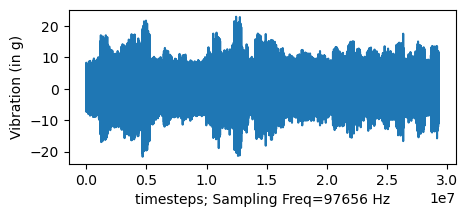

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,2),dpi=100)
plt.plot(data)
plt.xlabel('timesteps; Sampling Freq=97656 Hz')
plt.ylabel('Vibration (in g)')
plt.show()

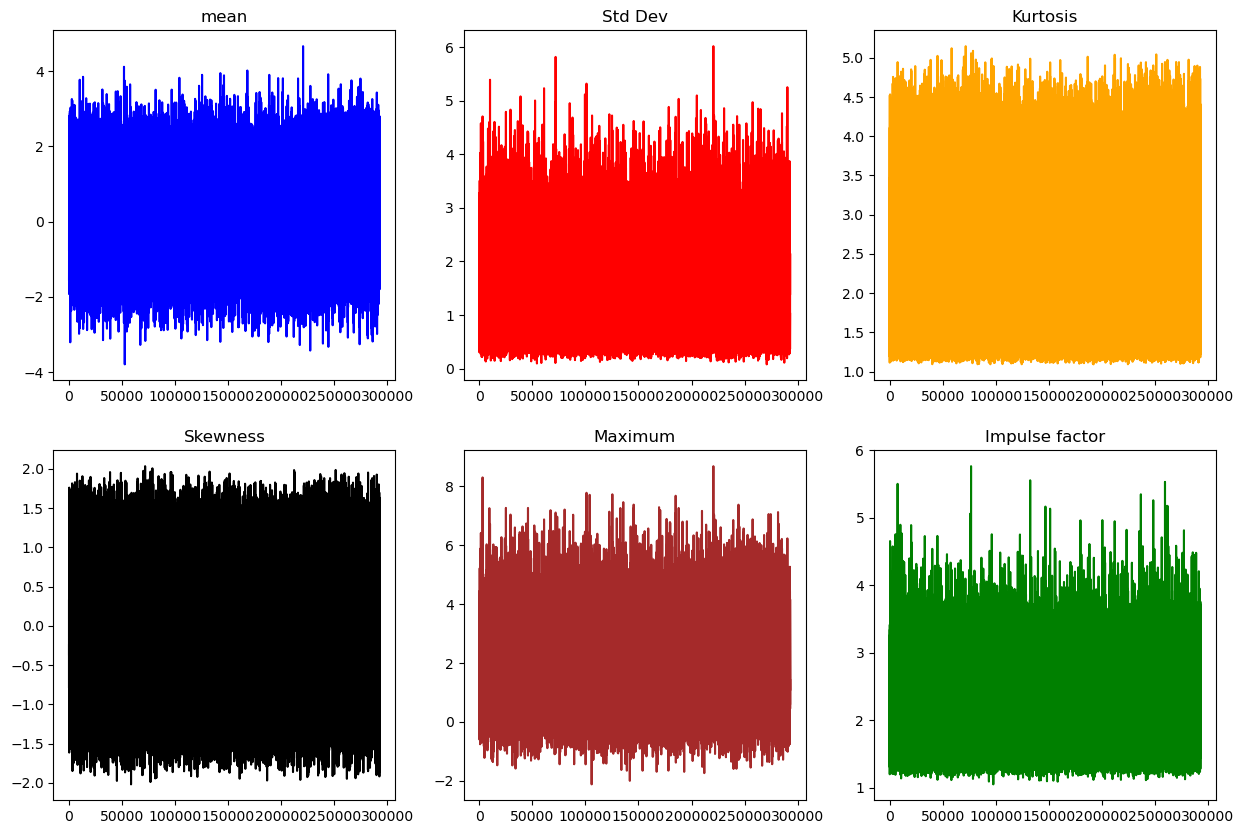

In [8]:
colors=['blue','red','orange','black','brown','Green']
feature_name=['mean','Std Dev','Kurtosis','Skewness','Maximum','Impulse factor']
import math
plt.figure(figsize=(15,10),dpi=100)
for i in range(features.shape[1]):
    plt.subplot(2,3,i+1)
    plt.plot((features[:int(data.shape[0]/100),i]),color=colors[i])
    plt.title(feature_name[i])

In [16]:
# loading dataset
print(len(processed))
x = range(len(processed[0]))
y = processed
y=y.reshape((y.shape[0],))
#plt.plot(y,color="green")
#plt.show()

29296794


In [17]:
y.shape

(29296794,)

In [11]:
fs=math.ceil(y.shape[0]/300)
print(fs)

97656


In [11]:
int(fs/10)

9765

In [18]:
trend_HI = np.lib.stride_tricks.sliding_window_view(y,6*fs)[::6*fs]


In [ ]:
mean2=[]
for i in range(3000):
    mean2.append(np.mean(y[i+int(fs/10):(i+1)*int(fs/10)]))

In [21]:
trend_HI.shape

(49, 585936)

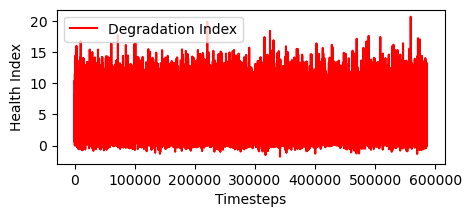

In [22]:
plt.figure(figsize=(5,2),dpi=100)
plt.plot(trend_HI[0,:],color='red',lw=1.5)
#plt.plot(pd.Series(mean2).rolling(window=10).mean(),color='red',lw=2.5,ls=":")
plt.xlabel('Timesteps')
plt.ylabel('Health Index')
plt.legend(['Degradation Index'])

In [ ]:
import pandas as pd
df_export=pd.DataFrame(mean2)
df_export.to_excel('/content/drive/MyDrive/Wind Turbine Vibration Data/WT-Prognosis-HSB-Kaggle/WT-Prognostics-MATLAB/vibration_signal.xlsx')

In [14]:
from sklearn.preprocessing import MinMaxScaler
def RUL(mean2):
    mean2=mean2.reshape(-1,1)
    scaler=MinMaxScaler()
    mean2_normalized=scaler.fit_transform(mean2)
    return 1-mean2_normalized


In [15]:
RUL=RUL(np.array(mean2))

In [16]:
Ground_truth=np.linspace(1, 0, num=3000)

In [17]:
Ground_truth_test=Ground_truth[2100:]

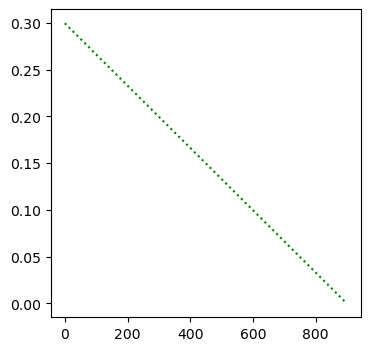

In [18]:
plt.figure(figsize=(4,4),dpi=100)
plt.plot(Ground_truth_test,color='green',lw=1.5,ls=':')

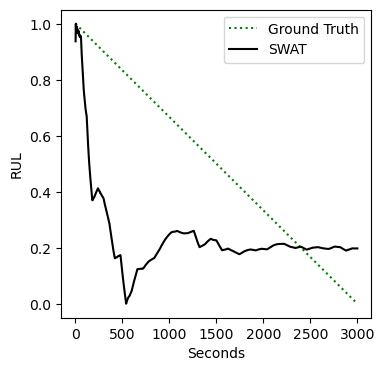

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4),dpi=100)
plt.plot(Ground_truth,color='green',lw=1.5,ls=':')
plt.plot(RUL,color='black',lw=1.5)
plt.xlabel('Seconds')
plt.ylabel('RUL')
plt.legend(['Ground Truth','SWAT'])

In [20]:
RUL
mask = np.isnan(RUL)
# assign 1 to the NaN values using the boolean mask
RUL[mask] = 1

In [21]:
print(RUL)

[[1.        ]
 [0.93704878]
 [0.97450636]
 ...
 [0.19761398]
 [0.19760207]
 [0.19753027]]


## RUL prediction using GRU, LSTM

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU,LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D


In [23]:
data=RUL

In [24]:
# split data into training and testing sets
train_size = 2100
train_data = data[:train_size]
test_data = data[train_size:]

# normalize the data using MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0, 1))
#train_data = scaler.fit_transform(train_data)
#test_data = scaler.transform(test_data)

# define the input and output sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5
train_X, train_y = create_sequences(train_data, seq_length)
test_X, test_y = create_sequences(test_data, seq_length)

In [25]:
print(train_X.shape)

(2095, 5, 1)


In [26]:
# build the GRU model
model = Sequential()

#GRU Network
#model.add(GRU(units=50, input_shape=(train_X.shape[1], train_X.shape[2])))

#Single Layer LSTM
#model.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))

#Stacked LSTM
#model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(100, activation='relu', return_sequences=True))
#model.add(LSTM(100, activation='relu'))

#1-D CNN
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))


model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit the model to the training data
history=model.fit(train_X, train_y, validation_split=0.15, epochs=50, batch_size=128, verbose=0)

# make predictions on the test data
y_pred = model.predict(test_X)

# rescale the predictions and the actual values
#y_pred = scaler.inverse_transform(y_pred)
#test_y = scaler.inverse_transform(test_y)

# calculate the root mean squared error
rmse = np.sqrt(np.mean((y_pred - test_y)**2))
print('RMSE: %.2f' % rmse)

2023-07-31 20:07:35.727989: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


28/28 [==============================] - 0s 2ms/step
RMSE: 0.00


In [ ]:
#plt.plot(history.history['loss'], label = 'training loss')
#plt.plot(history.history['val_loss'], label ='validation loss')
#plt.legend()

# **Gaussian Process Regression (GPR)**

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


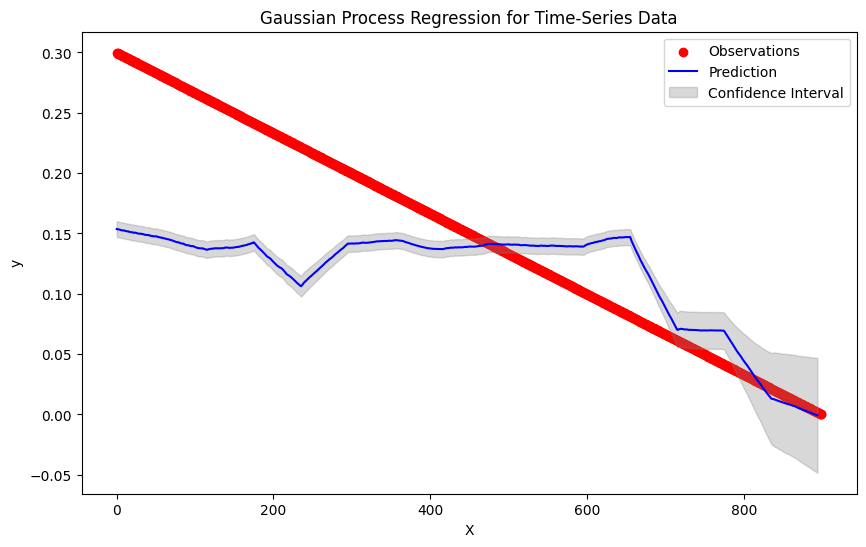

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel



# Define the Gaussian process regression model
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=0.9)
gpr = GaussianProcessRegressor(kernel=kernel)

# Fit the model to the data
gpr.fit(train_X.reshape((train_X.shape[0],train_X.shape[1])), train_y)

# Generate test data for prediction

# Make predictions with the trained model
y_pred, y_std = gpr.predict(test_X.reshape((test_X.shape[0],test_X.shape[1])), return_std=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(0,900,1),Ground_truth_test, c='red', label='Observations',lw=1)
plt.plot(np.arange(0,895,1), y_pred, color='blue', label='Prediction')
plt.fill_between(np.arange(0,895,1).squeeze(), (y_pred - 2 * y_std).squeeze(), (y_pred + 2 * y_std).squeeze(), color='gray', alpha=0.3, label='Confidence Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Gaussian Process Regression for Time-Series Data')
plt.legend()
plt.show()

In [ ]:
y_pred=y_pred.reshape((y_pred.shape[0],1))

In [ ]:
import pandas as pd
final_predictions=pd.DataFrame()
final_predictions.index=np.arange(0,895,1)

In [ ]:
final_predictions['GPR']=y_pred

In [ ]:
print(final_predictions)

     Stacked LSTM      LSTM       GRU       CNN       GPR
0        0.182083  0.196227  0.163098  0.156310  0.153654
1        0.182020  0.196144  0.162989  0.156243  0.153423
2        0.181986  0.196087  0.162904  0.156190  0.153410
3        0.181915  0.196005  0.162799  0.156069  0.153295
4        0.181836  0.195910  0.162677  0.155941  0.153053
..            ...       ...       ...       ...       ...
890      0.095429  0.091490  0.023231  0.034699  0.000197
891      0.095305  0.091334  0.023013  0.034587  0.000023
892      0.095190  0.091183  0.022800  0.034475 -0.000237
893      0.095068  0.091029  0.022587  0.034371 -0.000451
894      0.094969  0.090880  0.022368  0.034294 -0.000754

[895 rows x 5 columns]


In [ ]:
final_predictions.to_excel('/content/drive/MyDrive/Wind Turbine Vibration Data/WT-Prognosis-HSB-Kaggle/WT-Prognostics-MATLAB/predictions.xlsx')

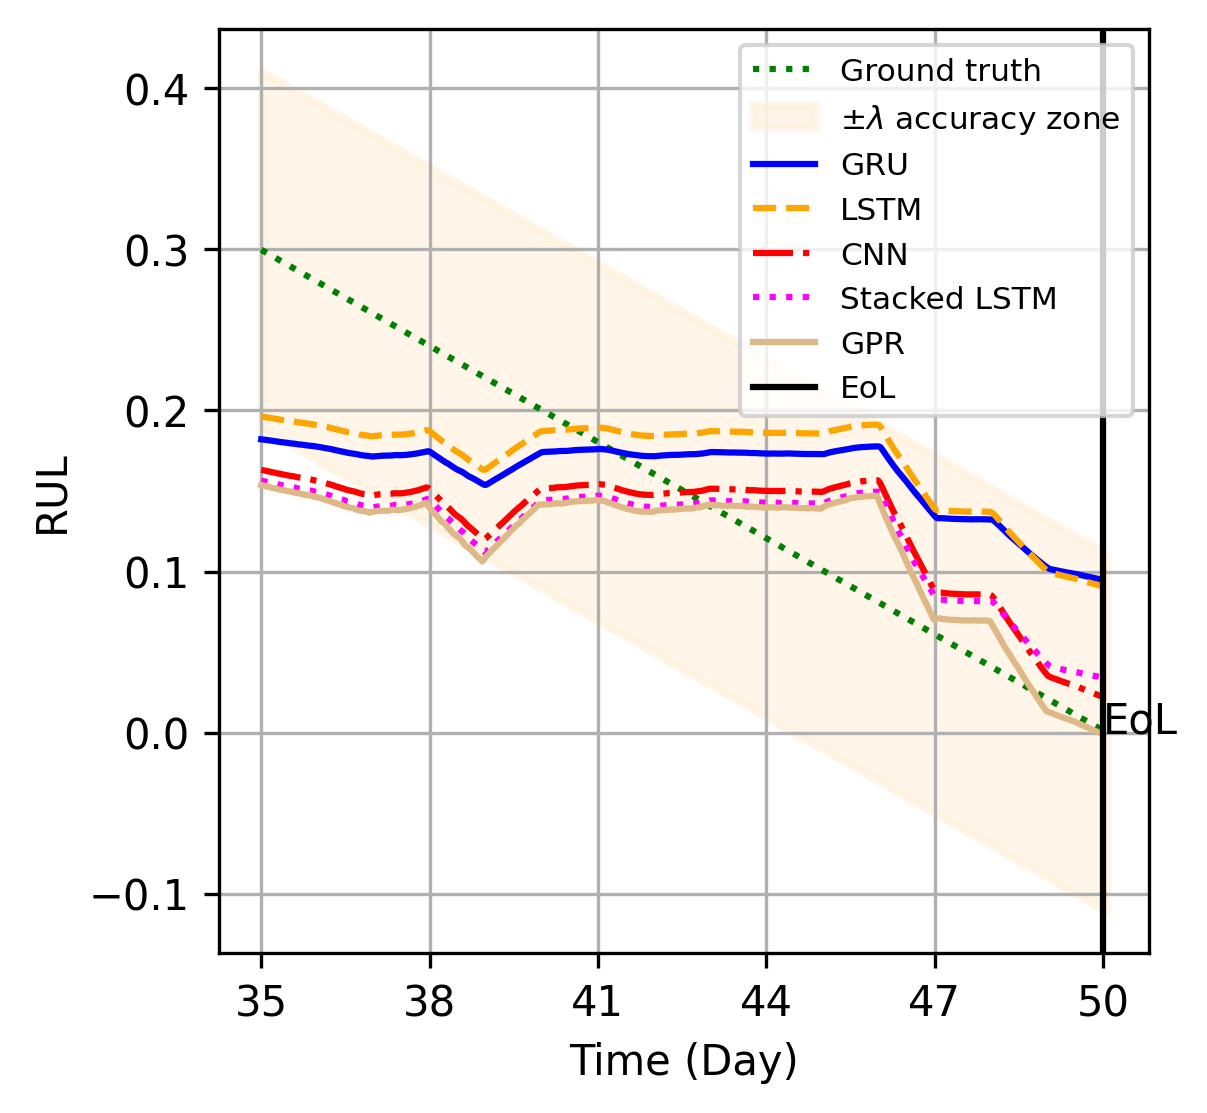

In [ ]:
colors=['blue','orange','red','magenta','burlywood']
ls=['solid','dashed','dashdot','dotted','solid']
plt.style.available
plt.figure(dpi=300,figsize=(4,4))
style = dict(size=10, color='black')
UB_x=Ground_truth_test+1.28*np.std(Ground_truth_test)
LB_x=Ground_truth_test-1.28*np.std(Ground_truth_test)
plt.plot(np.arange(0,900,1),Ground_truth_test,color='green',lw=1.5,ls=':')
plt.fill_between(np.arange(0,900,1),LB_x,UB_x,color='papayawhip',alpha=0.5,lw=2)
for i in range(5):
    plt.plot(np.arange(0,895,1),final_predictions.iloc[:,i],color=colors[i],ls=ls[i])
plt.axvline(895, 0, 1, label='EoL',color='black')
plt.text(895, 0, "EoL", **style)
plt.style.use('default')
plt.xlabel('Time (Day)')
#plt.xticks(list(np.linspace(0,895,6)),['15','12','9','6','3','0'])
plt.xticks(list(np.linspace(0,895,6)),['35','38','41','44','47','50'])
plt.ylabel('RUL')
#plt.title('SWAT- CNN')
plt.legend(['Ground truth',r'$\pm \lambda$ accuracy zone','GRU','LSTM','CNN','Stacked LSTM','GPR','EoL'],loc='upper right',fontsize=7.5)
plt.grid(1)

In [ ]:
def error_metrics(Ground_truth_test,y_pred):
    mae=np.mean(abs(Ground_truth_test-y_pred))
    mse= np.mean((Ground_truth_test-y_pred)**2)
    rmse=math.sqrt(mse)
    mape=np.mean(abs((Ground_truth_test-y_pred)/(Ground_truth_test+0.00001)))*100
    r2=1-np.sum((np.mean(Ground_truth_test)-y_pred)**2)/np.sum((Ground_truth_test-np.mean(Ground_truth_test))**2)

    return {'MAE':mae,'MSE':mse,'RMSE':rmse,'MAPE':mape,'R2':r2}

In [ ]:
error_metrics(Ground_truth_test,y_pred)

{'MAE': 0.08476510866191436,
 'MSE': 0.010428007378092944,
 'RMSE': 0.10211761541523061,
 'MAPE': 1535.63395104395,
 'R2': 0.6126878354612253}

## Relative Accuracy

In [ ]:
time_instant=[225,450,675,894]
ra=[]
GT=Ground_truth_test

In [ ]:
ra=np.empty([4,1])
for i in range(4):
        ra[i,:]=(1-abs(GT[time_instant[i]]-y_pred[time_instant[i],:])/GT[time_instant[i]])

In [ ]:
print(ra)

[[ 0.49958693]
 [ 0.92922149]
 [ 0.39705056]
 [-0.45219234]]
